#Modern portfolio theory
this workbook covers some prequisits for the DS exam, including:
- libraries needed for the analysis
- download stock prices from Yahoo! Finance using yfinance
- carving out closing prices from Yahoo! downloads
- stock KPIs, statistics
- portfolio KPIs
- Maximum Sharpe Ratio portfolio
- Minimum Variance portfolio
- Target Return portfolio
- Efficient frontier

### packages needed for the analysis
- I have collected the libraries needed for the entire analysis.
- the list covers more then actually needed to support other analysis.

note: colab simplye deletes the non-standard installations, maybe every day.
thus, you have to run the pip installs to get the packages imported.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import seaborn as sns
import scipy.optimize as sc
from scipy.stats import linregress

### seed collection


Seed values ensure that random number generation is reproducible and, to some extent, controlled. By setting a seed, the sequence of "random" numbers remains the same each time you run the code, which is useful for debugging, testing, and experimentation. While randomness still exists, setting the seed allows you to replay or share specific scenarios. To make it memorable, use your favorite numbers as seeds.

For fun, I collected some cool numbers for your entertainment — enjoy exploring the randomness!


- 1337 — Leet (elite) speak, popular in hacker culture.
- 007 — James Bond
- 008 - and his colleague
- 1701 — The registry number of the USS Enterprise from Star Trek.
- 1138 - George Lucas' directorial debut, appears in StarWars
- 101 -  Matrix, Neos appartman number.
- 6EQUJ5 - wow! signal - use it as hash(6EQUJ5)
- 88 - the speed required to go Back to the Future.
- 2187 - The number of Princess Leia's detention cell on Death Star.
- 1984 — A nod to George Orwell’s famous dystopian novel.
- 808 — Famous Roland TR-808 drum machine, iconic in electronic music.
- 42 — The original Hitchhiker’s Guide to the Galaxy number.
- 314 — A reference to Pi (3.14), cool for math enthusiasts.
- 1618 — The first few digits of the golden ratio (1.618033...).
- 12345 — the secret password from Spaceballs.
- 1967 - my year of birth
- 536 - the year of Late Antique Little Ice Age in Europe
- 1986 - Chernobyl Disaster
- 12 - twelve monkey, dirty dozen, blues
- 66 - order ended the Jedis in Star Wars
- 426 - LV-426 Acheron the moon Xenomorph is first encountered by humans
- 51 - Area 51 the popular landing site of UFOs
- 52 - Area 52 the ugly neighborhood (Dugway Proving Ground military testing facility).
- 0077 — Agent "Double-O Seven" but with extra flair.
- 404 — Annoying "not found" error code, you don't find it, debugging vibes.
- 1331 — A palindrome number, satisfying for symmetry lovers.
- 777 — Jackpot! For a bit of luck from the slot machines.
- 24601 — Jean Valjean's prisoner number in Les Misérables.
- 9000 — "I'm sorry, Dave. I'm afraid I can't do that." — HAL 9000 from 2001: A Space Odyssey.
- 8675309 — Jenny's number from the famous 1980s song "867-5309/Jenny."
- 1492 — The year Columbus sailed the ocean blue, a nod to historical events.
- 221 — Sherlock Holmes' iconic address at 221B Baker Street.
- 451 — Fahrenheit 451 by Ray Bradbury, representing censorship and dystopia.
- 1776 — The year of the U.S. Declaration of Independence.
- 1985 — The year Marty McFly travels back to in Back to the Future.
- 2015 - The future of Marty McFly back in the Future.
- 300 — The brave Spartans of 300, a movie reference.
- 1999 — Party like it’s 1999! A nod to Prince’s iconic song.



In [2]:
seed = 51 #
np.random.seed(seed)
# this seed is used to retain all random values in this analysis.

### Yahoo! Finance download
- technique to download stock prices directly from Yahoo!
- note: this section does not deal with the data frame split

#### Meta data you get with the download
Yahoo! Finance is a powerful financial platform that provides users with a vast amount of company data, market insights, and financial information. Through partnerships with data providers, regulatory filings, and stock exchanges, Yahoo! Finance aggregates key metrics such as real-time stock prices, financial statements, company profiles, and historical performance. Whether you’re tracking the latest news, analyzing sectors, or diving into detailed earnings reports, Yahoo! Finance offers comprehensive tools for investors, making it a go-to source for all levels of financial analysis.



In [3]:
pick = 'CEG' # make your random pick, if you know some tickers
yf.Ticker(pick).info

{'address1': '1310 Point Street',
 'city': 'Baltimore',
 'state': 'MD',
 'zip': '21231-3380',
 'country': 'United States',
 'phone': '833 883 0162',
 'website': 'https://www.constellationenergy.com',
 'industry': 'Utilities - Renewable',
 'industryKey': 'utilities-renewable',
 'industryDisp': 'Utilities - Renewable',
 'sector': 'Utilities',
 'sectorKey': 'utilities',
 'sectorDisp': 'Utilities',
 'longBusinessSummary': 'Constellation Energy Corporation generates and sells electricity in the United States. It operates through five segments: Mid-Atlantic, Midwest, New York, ERCOT, and Other Power Regions. The company sells natural gas, energy-related products, and sustainable solutions. It has approximately 33,094 megawatts of generating capacity consisting of nuclear, wind, solar, natural gas, and hydroelectric assets. It serves distribution utilities; municipalities; cooperatives; and commercial, industrial, governmental, and residential customers. The company was incorporated in 2021 a

In [4]:
short_name = yf.Ticker(pick).info.get('shortName')
sector = yf.Ticker(pick).info.get('sector')
print(f'symbol: {pick}, company: {short_name}, sector: {sector}')

symbol: CEG, company: Constellation Energy Corporatio, sector: Utilities


In [5]:
url = 'https://datahub.io/core/s-and-p-500-companies/r/constituents.csv'
sp500_tickers = pd.read_csv(url)

# Get the list of tickers, randomly by using sample
num_of_symbols = 100
tickers_list = sp500_tickers['Symbol'].sample(num_of_symbols, random_state=seed).tolist() # randome_state is the seed for the random choice

In [6]:
def get_company_info(tickers_list):
    """
    Fetch company names and sectors for a given list of tickers from Yahoo Finance.

    Parameters:
    tickers_list (list): List of ticker symbols to fetch data for.

    Returns:
    pd.DataFrame: DataFrame with company names and sectors, with tickers as index.
    """
    company_names = []
    sectors = []
    industry = []
    revenues = []
    ebitda = []

    # Loop through each ticker to get the data
    for ticker in tickers_list:
        stock = yf.Ticker(ticker)
        info = stock.info
        company_names.append(info.get('shortName', 'N/A'))  # Get company name, 'N/A' if not available
        sectors.append(info.get('sector', 'N/A'))  # Get sector, 'N/A' if not available
        industry.append(info.get('industry', 'N/A'))
        revenues.append(f"{info.get('totalRevenue', 'N/A'):,.0f}" if info.get('totalRevenue', 'N/A') != 'N/A' else 'N/A')
        ebitda.append(f"{info.get('ebitda', 'N/A'):,.0f}" if info.get('ebitda', 'N/A') != 'N/A' else 'N/A')



    # Create a DataFrame with tickers as the index, and columns for company name and sector
    df = pd.DataFrame({
        'company_name': company_names,
        'sector': sectors,
        'revenues': revenues,
        'ebitda': ebitda

    }, index=tickers_list)

    return df

In [7]:
# fetching key company info relevant for further analysis
# this is illustrative only, efficient frontier does not consider meta info
get_company_info(tickers_list)

,company_name,sector,revenues,ebitda
CI,The Cigna Group,Healthcare,"229,746,999,296","8,554,999,808"
PEP,"Pepsico, Inc.",Consumer Defensive,"91,919,998,976","16,913,000,448"
PSX,Phillips 66,Energy,"147,738,001,408","5,571,999,744"
CMCSA,Comcast Corporation,Communication Services,"123,069,997,056","37,285,998,592"
CEG,Constellation Energy Corporatio,Utilities,"23,544,000,512","5,585,999,872"
...,...,...,...,...
GRMN,Garmin Ltd.,Technology,"5,956,843,008","1,596,897,024"
APD,"Air Products and Chemicals, Inc",Basic Materials,"12,104,399,872","4,200,199,936"
WELL,Welltower Inc.,Real Estate,"7,555,548,160","2,930,661,888"
A,"Agilent Technologies, Inc.",Healthcare,"6,496,999,936","1,564,000,000"


#### Data Frame


In [8]:
#Yahoo! connector to download the prices
stocks = tickers_list
start_date = '2020-01-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d') # until today

In [9]:
data = yf.download(stocks, start=start_date, end=end_date)

[*********************100%***********************]  100 of 100 completed


In [10]:
data.tail()
# Yahoo! downloads the data ordered according to its database

Price                       Adj Close                                     \
Ticker                              A        AAPL        ACGL        AES   
Date                                                                       
2024-10-28 00:00:00+00:00  131.539993  233.399994  105.660004  16.871124   
2024-10-29 00:00:00+00:00  131.229996  233.669998  104.800003  16.346685   
2024-10-30 00:00:00+00:00  131.490005  230.100006  105.139999  16.247734   
2024-10-31 00:00:00+00:00  130.309998  225.910004   98.559998  16.316999   
2024-11-01 00:00:00+00:00  136.869995  222.910004   96.019997  14.710000   

Price                                                                  \
Ticker                      AMCR         AMT         APD          AZO   
Date                                                                    
2024-10-28 00:00:00+00:00  11.08  222.220001  318.260010  3105.929932   
2024-10-29 00:00:00+00:00  10.93  212.910004  315.299988  3060.889893   
2024-10-30 00:00:00+00:00  11.06  213.479996  312.769989  3017.979980   
2024-10-31 00:00:00+00:00  11.13  213.539993  310.529999  3009.000000   
2024-11-01 00:00:00+00:00  10.26  211.259995  309.209991  2981.189941   

Price                                             ...    Volume           \
Ticker                             BA       BALL  ...      UBER      UPS   
Date                                              ...                      
2024-10-28 00:00:00+00:00  150.690002  64.589996  ...   9311900  4069000   
2024-10-29 00:00:00+00:00  152.979996  63.290001  ...  14469600  3061700   
2024-10-30 00:00:00+00:00  154.289993  64.190002  ...  14997700  2754600   
2024-10-31 00:00:00+00:00  149.309998  59.250000  ...  64047100  3303600   
2024-11-01 00:00:00+00:00  154.589996  59.009998  ...  33529000  2264200   

Price                                                                    \
Ticker                         VMC      VST       WBA     WELL      WMB   
Date                                                                      
2024-10-28 00:00:00+00:00  1437500  5213300  16275200  2282300  5026500   
2024-10-29 00:00:00+00:00  1183000  4738600  17788500  4160400  7903400   
2024-10-30 00:00:00+00:00  1952100  4166500  13504000  3679200  5524300   
2024-10-31 00:00:00+00:00  1429200  4073500  17058600  3980900  5902500   
2024-11-01 00:00:00+00:00   986500  5885300  12188500  2217100  5640300   

Price                                                 
Ticker                         WST     WYNN      XEL  
Date                                                  
2024-10-28 00:00:00+00:00   801500  1062200  4165700  
2024-10-29 00:00:00+00:00  1043300  1890200  6475700  
2024-10-30 00:00:00+00:00   672100  1337100  2894400  
2024-10-31 00:00:00+00:00   966400  1897300  6805300  
2024-11-01 00:00:00+00:00   623700  1737200  6861000  

[5 rows x 600 columns]

In [11]:
# you need to reorder the header, according to tickers_list
# this also possible with a loop, but this reindex is more elegant.
data = data.reindex(columns=pd.MultiIndex.from_product([data.columns.levels[0], tickers_list]))

In [12]:
data.head() # you need to check the header structure. It may confuse the data frame - take care

Price                       Adj Close                                        \
                                   CI         PEP        PSX      CMCSA CEG   
Date                                                                          
2020-01-02 00:00:00+00:00  192.106415  118.635849  91.679047  40.050068 NaN   
2020-01-03 00:00:00+00:00  190.456589  118.469894  88.647560  39.732273 NaN   
2020-01-06 00:00:00+00:00  193.962357  118.924103  88.091957  39.432140 NaN   
2020-01-07 00:00:00+00:00  194.909134  117.054832  88.361595  39.848995 NaN   
2020-01-08 00:00:00+00:00  198.171234  117.657570  85.060493  40.256981 NaN   

Price                                                                    \
                                 WYNN         PNC       STLD         SO   
Date                                                                      
2020-01-02 00:00:00+00:00  140.138107  133.292099  30.734800  51.756004   
2020-01-03 00:00:00+00:00  138.059448  132.012115  30.189217  51.706413   
2020-01-06 00:00:00+00:00  137.786209  131.746124  30.098286  51.913044   
2020-01-07 00:00:00+00:00  138.440033  130.707199  30.762085  51.756004   
2020-01-08 00:00:00+00:00  139.308594  132.061996  30.789360  51.739471   

Price                                  ...    Volume                    \
                                 MKTX  ...       KMI      BAX     ROST   
Date                                   ...                               
2020-01-02 00:00:00+00:00  364.906677  ...  10373100  2957800  1722500   
2020-01-03 00:00:00+00:00  364.714691  ...  10148700  1871700  1486500   
2020-01-06 00:00:00+00:00  358.985565  ...  13978300  3500000  1573600   
2020-01-07 00:00:00+00:00  360.108368  ...  14736900  4803200  1961900   
2020-01-08 00:00:00+00:00  349.600220  ...  10651500  3576600  1565200   

Price                                                                          \
                             ORLY     MTB     GRMN      APD     WELL        A   
Date                                                                            
2020-01-02 00:00:00+00:00  796100  509100   828000  1320500  2049100  1410500   
2020-01-03 00:00:00+00:00  482900  461900   503800  1710400  1687000  1118300   
2020-01-06 00:00:00+00:00  837100  372900   686200  1737400  2201200  1993200   
2020-01-07 00:00:00+00:00  661500  324800   781200  1518900  1239500  1684700   
2020-01-08 00:00:00+00:00  479500  462500  1080000   965700  2016800  1847600   

Price                              
                              DPZ  
Date                               
2020-01-02 00:00:00+00:00  500000  
2020-01-03 00:00:00+00:00  490800  
2020-01-06 00:00:00+00:00  525400  
2020-01-07 00:00:00+00:00  501000  
2020-01-08 00:00:00+00:00  543000  

[5 rows x 600 columns]

In [13]:
# you also need to check if the index is a timestamp (date)
# if it is a text, then you have to change its type to datetime (datetime library)
type(data.index[0]) # this is to check if the index first item is time

pandas._libs.tslibs.timestamps.Timestamp

### getting the stock prices



In [14]:
stock_close = data['Adj Close']
stock_volume = data['Volume']

In [15]:
stock_close.head() # stock closing prices mainly used for the calculation

,CI,PEP,PSX,CMCSA,CEG,WYNN,PNC,STLD,SO,MKTX,...,KMI,BAX,ROST,ORLY,MTB,GRMN,APD,WELL,A,DPZ
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,192.106415,118.635849,91.679047,40.050068,NaN,140.138107,133.292099,30.734800,51.756004,364.906677,...,15.312106,78.079254,111.634972,437.519989,145.778442,87.693764,206.406891,68.426224,83.214874,278.352081
2020-01-03 00:00:00+00:00,190.456589,118.469894,88.647560,39.732273,NaN,138.059448,132.012115,30.189217,51.706413,364.714691,...,15.428554,77.742805,111.663635,438.750000,144.287170,87.131973,201.816895,69.630142,81.878792,279.556946
2020-01-06 00:00:00+00:00,193.962357,118.924103,88.091957,39.432140,NaN,137.786209,131.746124,30.098286,51.913044,358.985565,...,15.486774,77.551857,112.208305,434.660004,143.094116,87.114136,201.727554,70.688889,82.120850,278.873932
2020-01-07 00:00:00+00:00,194.909134,117.054832,88.361595,39.848995,NaN,138.440033,130.707199,30.762085,51.756004,360.108368,...,15.523163,77.733719,113.517380,428.769989,141.364258,86.980377,202.584900,70.227837,82.372559,276.881683
2020-01-08 00:00:00+00:00,198.171234,117.657570,85.060493,40.256981,NaN,139.308594,132.061996,30.789360,51.739471,349.600220,...,15.399441,78.861214,113.851814,431.899994,142.080048,86.498825,203.683273,70.244904,83.185822,275.657837


In [16]:
stock_close.info()
# check the values for missing data
'''
at certain cenarios (example: seed=300, The brave Spartans of 300, a movie reference), we might have missing values (stock trading did not start.
the ones are caused my problem: PLTR    1025 non-null, VLTO    268 non-null,  89  CEG     697. their trading stated later.

to handle these situations, I had to modify the stock_KPIs function and the cov_matrix calculation.

the issue: fillna(0) for long periods generates singular cov_matrix (you do not have inverse matrix), as the zeros fully collerate to each other.
methods of backfill and forward fill generates made up stock prices, which changes the mean_returns (if you fill up the stock prices)
you may backfill and forward fill the daily_returns however, this method still creates data for the period when the trading did not exist.
dropna() deletes all stock prices from the data frame, when we loose data.

the solution I liked to most:
- we skip the nan days in the daily_return calculation only for the individual stocks
- when calculation the cov_matrix we use some methods to ensure cov_matrix has not too correct data only when the missing value stocks are involved in the calculation.
- the concept: keep as much valid data as possible, and ignore the data generation.
the method consist of:
- modification of daily_returns calculation
- Pairwise Deletion for Covariance Calculation and
explanations in the comments of the functions.
'''

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2020-01-02 00:00:00+00:00 to 2024-11-01 00:00:00+00:00
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CI      1218 non-null   float64
 1   PEP     1218 non-null   float64
 2   PSX     1218 non-null   float64
 3   CMCSA   1218 non-null   float64
 4   CEG     702 non-null    float64
 5   WYNN    1218 non-null   float64
 6   PNC     1218 non-null   float64
 7   STLD    1218 non-null   float64
 8   SO      1218 non-null   float64
 9   MKTX    1218 non-null   float64
 10  MRO     1218 non-null   float64
 11  BALL    1218 non-null   float64
 12  MCHP    1218 non-null   float64
 13  AMCR    1218 non-null   float64
 14  AZO     1218 non-null   float64
 15  IEX     1218 non-null   float64
 16  FICO    1218 non-null   float64
 17  XEL     1218 non-null   float64
 18  UBER    1218 non-null   float64
 19  GIS     1218 non-null   float64
 20  CHTR    1218 non-null   f

'\nat certain cenarios (example: seed=300, The brave Spartans of 300, a movie reference), we might have missing values (stock trading did not start.\nthe ones are caused my problem: PLTR    1025 non-null, VLTO    268 non-null,  89  CEG     697. their trading stated later.\n\nto handle these situations, I had to modify the stock_KPIs function and the cov_matrix calculation.\n\nthe issue: fillna(0) for long periods generates singular cov_matrix (you do not have inverse matrix), as the zeros fully collerate to each other.\nmethods of backfill and forward fill generates made up stock prices, which changes the mean_returns (if you fill up the stock prices)\nyou may backfill and forward fill the daily_returns however, this method still creates data for the period when the trading did not exist.\ndropna() deletes all stock prices from the data frame, when we loose data.\n\nthe solution I liked to most:\n- we skip the nan days in the daily_return calculation only for the individual stocks\n- w

<Axes: xlabel='Date'>

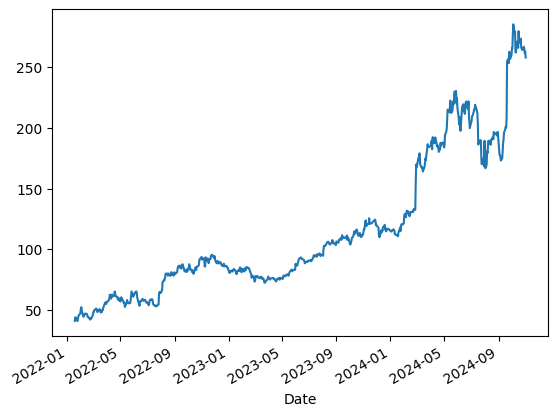

In [17]:
stock_close['CEG'].plot(kind='line') # example: VLTO trading started in 2023 only. We have missing data.

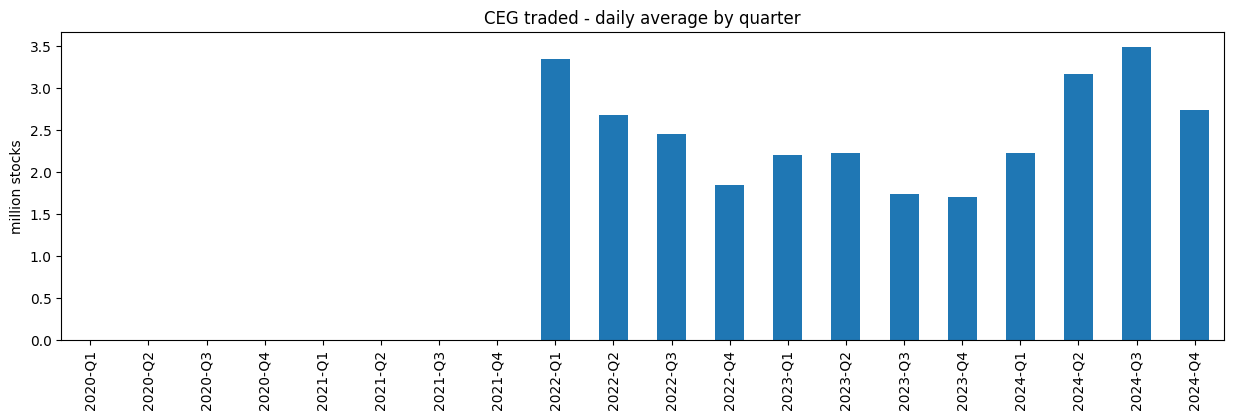

In [18]:
# more complex groupped volume chart
pick='CEG'
st_vol = stock_volume.reset_index() # move the date out of index
st_vol['quarter'] = st_vol['Date'].dt.year.astype(str) + '-Q' + st_vol['Date'].dt.quarter.astype(str) # create quarterly
st_vol['period'] = st_vol['Date'].dt.strftime('%Y-%m')
st_vol.set_index('Date', inplace=True)
quarter_avg = st_vol.groupby('quarter')[pick].mean()/1e6
fig, ax = plt.subplots(figsize=(15, 4))
quarter_avg.plot(kind='bar', ax=ax)
plt.title(f'{pick} traded - daily average by quarter')
plt.xlabel('')
plt.ylabel('million stocks')
plt.show()

### stock KPIs


In [19]:

def stock_KPIs(dataframe, start_date, end_date):
    '''
    Explanation
    Daily Returns Calculation: The calculate_individual_returns function calculates returns per stock, leaving NaN where data is missing, so no artificial data is introduced.
    Mean Returns Calculation: Using mean(skipna=True) calculates the mean for each stock based only on existing data, ignoring NaN values.
    Covariance Matrix Calculation: The covariance matrix is calculated using pairwise deletion (min_periods=1), so each covariance value is based only on dates where both stocks have available data.
    '''

    filtered_df = dataframe.loc[start_date:end_date] # option to slice the data frame by date
    filtered_df = filtered_df.where(filtered_df > 0) # Replace zero or negative values with NaN (to handle cases where data might be invalid)
    filtered_df = filtered_df.ffill()  # Forward-fill only for zero or negative values that are transformed to NaN, Note: This still keeps original missing values as NaN


    def calculate_individual_returns(df):
        # Calculate daily log returns without filling NaNs (preserves missing data)
        return df.apply(lambda x: np.log(x / x.shift(1)))

    p_daily_returns = calculate_individual_returns(filtered_df) # still keeps the non-trading periods
    mean_returns = p_daily_returns.mean(skipna=True) * 252  # Annualized mean returns ignoring NaNs
    variance = p_daily_returns.var(skipna=True) * 252 # Annualized variance ignoring NaNs
    volatility = p_daily_returns.std(skipna=True) * np.sqrt(252)  # Annualized standard deviation
    cov_matrix_pairwise = p_daily_returns.cov(min_periods=1) * 252  # Annualized pairwise covariance matrix

    return {
        'data_frame': filtered_df,
        'mean_returns': mean_returns,             # Annualized mean returns
        'variance': variance,
        'volatility': volatility,            # Annualized standard deviation
        'cov_matrix': cov_matrix_pairwise,  # Annualized pairwise covariance matrix
    }



In [22]:
mean_returns = stock_KPIs(stock_close, start_date, end_date) ['mean_returns'].rename('mean_returns')
variance = stock_KPIs(stock_close, start_date, end_date) ['variance'].rename('variance')
volatility = stock_KPIs(stock_close, start_date, end_date)['volatility'].rename('volatility')
cov_matrix = stock_KPIs(stock_close, start_date, end_date)['cov_matrix']

In [23]:
metrics = pd.DataFrame({
    'mean_returns': mean_returns,
    'variance': variance,
    'volatility': volatility
}, index=mean_returns.index)
metrics

,mean_returns,variance,volatility
CI,0.103376,0.113804,0.337348
PEP,0.069048,0.049416,0.222298
PSX,0.055759,0.186155,0.431456
CMCSA,0.017395,0.081127,0.284829
CEG,0.662244,0.180215,0.424518
...,...,...,...
GRMN,0.168827,0.088999,0.298327
APD,0.083690,0.094991,0.308206
WELL,0.138035,0.167615,0.409408
A,0.103037,0.089150,0.298580


<Axes: >

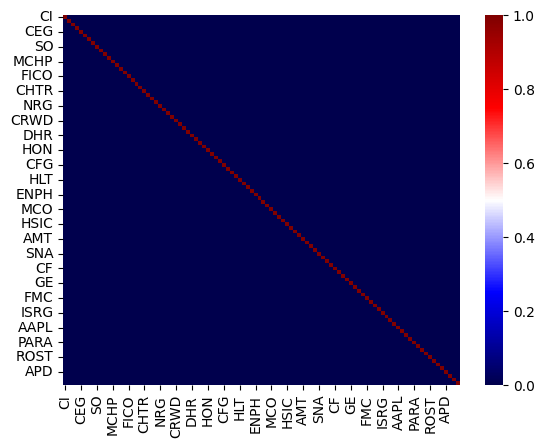

In [24]:
# checking the matrix inverse
inv_matrix = np.linalg.inv(cov_matrix)
np.set_printoptions(suppress=True, precision=6)
identity_matrix = pd.DataFrame(np.dot(cov_matrix, inv_matrix), index=cov_matrix.index, columns=cov_matrix.index).round(0)
sns.heatmap(identity_matrix, annot=False, fmt='0.27', cmap='seismic')

In [25]:
def base_chart(vols, returns):
    plt.figure(figsize=(15, 5))

    # Add labels and title
    plt.xlabel('Volatility (Annualized Std Dev)')
    plt.ylabel('Annualized Returns')
    plt.title('Stock Returns vs Volatility')

    # Remove the gridlines
    plt.grid(False)

    # Customize the axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set axis limits
    x_min = min(vols.min() - 0.1, 0)
    y_min = min(returns.min() - 0.1, 0)
    x_max = vols.max() + 0.2
    y_max = returns.max() + 0.2
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Customize the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

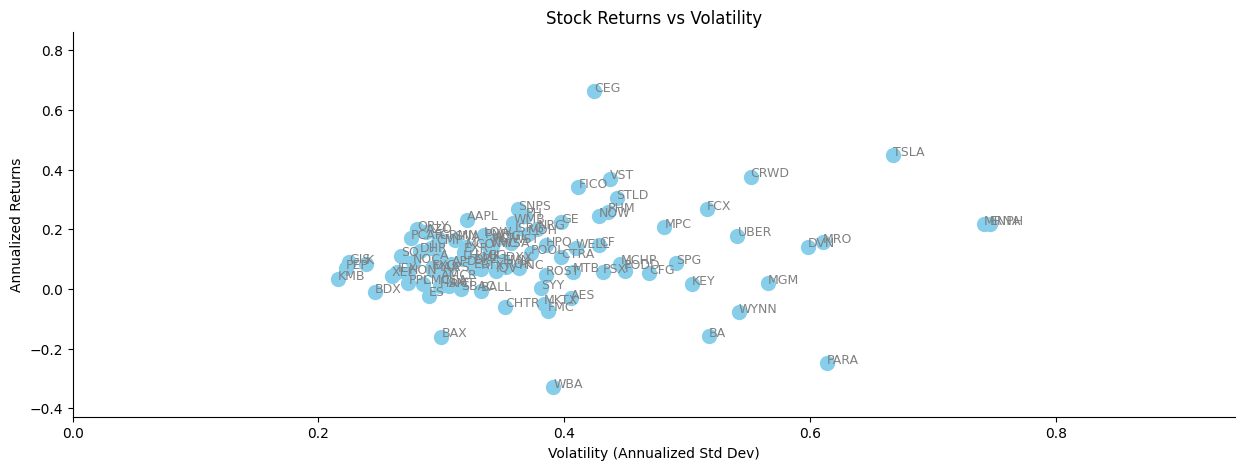

In [26]:
base_chart(volatility, mean_returns)
# add individual stock and their tickers:
plt.scatter(volatility, mean_returns, color='skyblue', s=100)
for i in range(len(mean_returns)):
  plt.text(volatility.iloc[i], mean_returns.iloc[i], mean_returns.index[i], fontsize=9, color='grey')

plt.show()

### functions to measure portoflio performance


In [27]:
def get_flat_ratios(cov_matrix):
  '''
  this function calculates the number of stocks from the covariance matrix, and
  calculates the weights for each stock. The weight ratio is equivalent to each stock.
  Use this function to get an initial portfolio weight.
  The calculated weights are stored in a list.
  '''
  ticker_list = cov_matrix.index.tolist()
  len_list = len(ticker_list)
  return [1/len_list for ticker in ticker_list]

initial_weights = get_flat_ratios(cov_matrix) # initial weights, flat ratio for each stock


In [28]:
def portfolio_return(weights, returns):
  weights_array = np.array(weights)
  returns = np.dot(weights_array,returns)
  return returns

def portfolio_variance(weights, cov_matrix):
  weights_array = np.array(weights)
  return np.dot(weights_array.T, np.dot(cov_matrix, weights_array))

def portfolio_volatility(weights, cov_matrix):
  weights_array = np.array(weights)
  variance = np.dot(weights_array.T, np.dot(cov_matrix, weights_array))
  return np.sqrt(variance)

def portfolio_KPIs(weights, returns, cov_matrix):
  '''
  the function uses a matrix calculation to get the portfolio returns and standard deviation
  the weights list is turned into an array.
  the output is a rounded fitgure for both returns and standard deviation
  '''
  weights_array = np.array(weights)
  returns = portfolio_return(weights, returns)
  variance = portfolio_variance(weights, cov_matrix)
  volatility = portfolio_volatility(weights, cov_matrix)
  return {
      'weights': weights_array,
      'returns': returns,
      'variance': variance,
      'volatility': volatility
  }

In [29]:
# quick review on how our data looks like so far:
portfolio_KPIs(initial_weights, mean_returns, cov_matrix)

{'weights': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01]),
 'returns': 0.10923039433613234,
 'variance': 0.0526051959479388,
 'volatility': 0.22935822624867588}

In [30]:
# quick review on how our data looks like so far:
'''
this step demonstrates how to use the functions
- we get the mean returns and covariance matrix from the stock_close data frame
- we calculate the weights from the covariance matrix
- we have all data to calculate the portfolio performance
'''
mean_returns = stock_KPIs(stock_close, start_date, end_date)['mean_returns']
cov_matrix = stock_KPIs(stock_close, start_date, end_date)['cov_matrix']
weights = get_flat_ratios(cov_matrix)
pr = portfolio_return(weights, mean_returns)
pv = portfolio_variance(weights, cov_matrix)
ps = portfolio_volatility(weights, cov_matrix)
print(f'The portfolio return: {pr * 100:.2f}%\n'
      f'The portfolio variance: {pv*10000:.4f}\n'
      f'The portfolio return volatility: {ps*100:.2f}%')

The portfolio return: 10.92%
The portfolio variance: 526.0520
The portfolio return volatility: 22.94%


### functions for portfolio optimization


In [31]:
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0):
    '''
    in our analysis fundamentally we are looking for the maximum sharpe ratio we can achiev with a portfolio set-up.
    this function takes the negative of the calculated sharpe ratio.
    turning the sharpe ratio into negative will help us to run the optimization algo for the minimum value
    as a result, we will have the maximum sharpe ratio at that point (after truning it back to positive again)
    '''
    p_return = portfolio_return(weights, returns) # Calculate portfolio return
    p_vol = portfolio_volatility(weights, cov_matrix)     # Calculate portfolio volatility (risk)
    sharpe_ratio = (p_return - risk_free_rate) / p_vol     # Calculate Sharpe ratio,
    return -sharpe_ratio # and we take the negative of it


In [32]:
def maximum_sharpe_portfolio(returns, cov_matrix, risk_free_rate=0.05, constraint_set=(0,1)):
    '''
    This function takes the stock data (mean_returns, cov_matrix) and an initial portfolio set.
    Using the scipy.optimize.minimize function, it finds the portfolio with the maximum Sharpe ratio by minimizing the negative Sharpe ratio.
    In other words, this provides the investor with an optimized risk-return scenario, achieving the highest possible return for a given level of risk.

    For more details on the 'result' structure, refer to the documentation for the SLSQP minimize function.
    In a nutshell: the Sharpe ratio calculation is in 'func', and the portfolio weights are in 'x'.
    '''

    num_assets = len(returns)
    args = (returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Ensure the weights sum to 1

    # Set bounds for each asset with minimum and maximum weights
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))

    # Generate a random initial guess for the portfolio weights
    initial_guess = np.random.dirichlet(np.ones(num_assets), size=1).flatten()

    # Perform optimization using SLSQP method
    result = sc.minimize(negative_sharpe_ratio, initial_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result


In [33]:
def minimum_volatile_portfolio(returns, cov_matrix, constraint_set=(0,1)):
    '''
    This function takes the stock data (mean_returns, cov_matrix) and an initial portfolio set.
    Using the scipy.optimize.minimize function, it finds the portfolio with the lowest volatility.
    In other words, this provides the investor with a possible low risk scenario

    For more details on the 'result' structure, refer to the documentation for the SLSQP minimize function.
    In a nutshell: the volatility calculation is in 'func', and the portfolio weights are in 'x'.
    '''

    num_assets = len(returns)

    args = (cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Ensure the weights sum to 1

    # Set bounds for each asset with minimum and maximum weights
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))

    # Generate a random initial guess for the portfolio weights
    initial_guess = np.random.dirichlet(np.ones(num_assets), size=1).flatten()

    # Perform optimization using SLSQP method
    result = sc.minimize(portfolio_volatility, initial_guess, args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [34]:
def target_portfolio(returns, cov_matrix, return_target, constraint_set=(0,1)):
    '''
    This function takes the stock data (mean_returns, cov_matrix) and an initial portfolio set.
    Using the scipy.optimize.minimize function, it finds the minimum volatility possible at a given target return.
    In other words, this provides the investor with a possible low risk scenario at his return expectation.

    For more details on the 'result' structure, refer to the documentation for the SLSQP minimize function.
    In a nutshell: the acheived sharpe ratio is in 'func', and the portfolio weights are in 'x'.
    '''
    num_assets = len(returns)

    args = (cov_matrix,)

    constraints = (
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, returns) - return_target},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )

    bounds = tuple(constraint_set for _ in range(num_assets))

    initial_guess = np.random.dirichlet(np.ones(num_assets), size=1).flatten()

    result = sc.minimize(
        portfolio_volatility,
        initial_guess,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}  # Suppress optimizer output
    )
    return result

### calculation results

this section gives you an overview of the above functin results

In [35]:
risk_free_rate = 0.05

In [36]:
msr_portfolio = maximum_sharpe_portfolio(returns=mean_returns, cov_matrix=cov_matrix, risk_free_rate=risk_free_rate)

In [37]:
mnv_portfolio = minimum_volatile_portfolio(mean_returns, cov_matrix)

In [38]:
return_msr = portfolio_return(msr_portfolio['x'], mean_returns)
volatility_msr = portfolio_volatility(msr_portfolio['x'], cov_matrix)
sharpe_msr = (return_msr-risk_free_rate)/volatility_msr
return_msr, volatility_msr, sharpe_msr

(0.504576291117774, 0.29952771115333154, 1.5176435240914035)

In [39]:
return_mnv = portfolio_return(mnv_portfolio['x'], mean_returns)
volatility_mnv = portfolio_volatility(mnv_portfolio['x'], cov_matrix)
sharpe_mnv = (return_mnv-risk_free_rate)/volatility_mnv
return_mnv, volatility_mnv, sharpe_mnv

(0.11264774687872849, 0.15187732897890455, 0.41248912724446274)

In [40]:
return_target = (return_msr + return_mnv) / 2
tr_portfolio = target_portfolio(mean_returns, cov_matrix, return_target)
return_tr = portfolio_return(tr_portfolio['x'], mean_returns)
volatility_tr = portfolio_volatility(tr_portfolio['x'], cov_matrix)
sharpe_tr = (return_tr - risk_free_rate) / volatility_tr
return_tr, volatility_tr, sharpe_tr


(0.30861201899882096, 0.19266011318230233, 1.3423225738174067)

### key portfolios

In [41]:
# we calculate the portfolio returns and volatility for each scenario (min volatility, maximum sharpe, target return)
key_portfolios = pd.DataFrame({
    'returns':[return_mnv, return_tr, return_msr],
    'volatility': [volatility_mnv, volatility_tr, volatility_msr],
    'sharpe_ratio': [sharpe_mnv, sharpe_tr, sharpe_msr]
    }, index= ['minimum volatility portfolio', 'target return portfolio', 'maximum sharpe portfolio' ])
key_portfolios

,returns,volatility,sharpe_ratio
minimum volatility portfolio,0.112648,0.151877,0.412489
target return portfolio,0.308612,0.192660,1.342323
maximum sharpe portfolio,0.504576,0.299528,1.517644


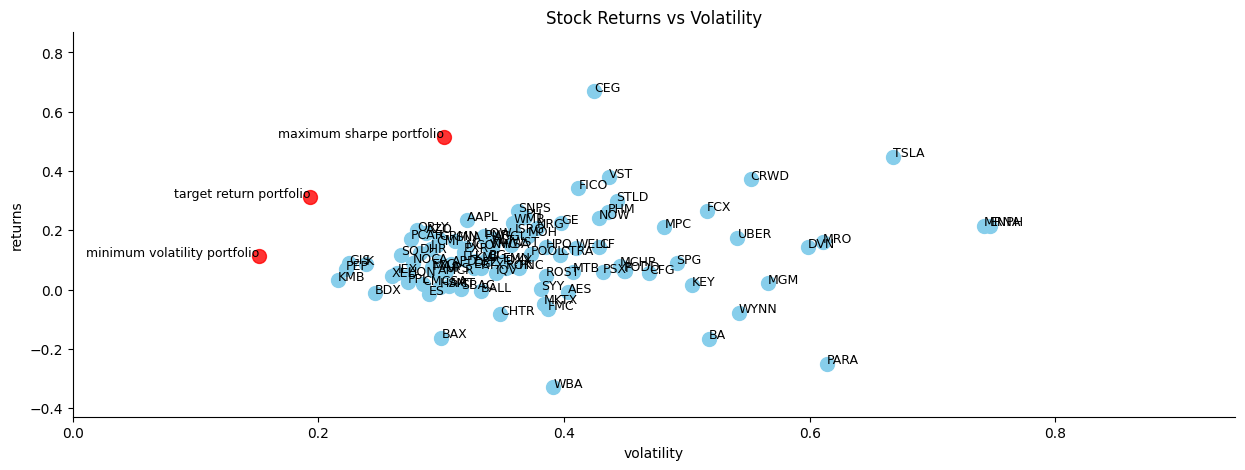

In [ ]:
base_chart(volatility, mean_returns)
# add individual stock and their tickers:
plt.scatter(volatility, mean_returns, color='skyblue', s=100)
for i in range(len(mean_returns)):
  plt.text(volatility.iloc[i], mean_returns.iloc[i], mean_returns.index[i], fontsize=9)
#add key portfolios
key_portfolios.plot(kind='scatter', x='volatility', y='returns', s=100, alpha=0.8, color='red', ax=plt.gca())
for i, row in key_portfolios.iterrows():
    plt.text(row['volatility'], row['returns'], i, fontsize=9, color='black', ha='right')

plt.show()

### efficient frontier

In [42]:
def efficient_forntier(returns, cov_matrix, min_returns, max_returns, num_iterate=20):
    '''
    this function calculates the efficient frontier, using the target return method.
    the function splits the minimum and maximum returns and calculates portfoli weights for each target return with possible lowest volatility
    as a result, the portfolios will form the efficient frontier
    '''
    efficient_list = []
    target_returns = np.linspace(min_returns, max_returns, num_iterate)# Run the optimizer and get the result object

    for target in target_returns:
      efficient_list.append(target_portfolio(returns, cov_matrix, target)['fun'])

    efficient_df = pd.DataFrame({
        'returns': target_returns,
        'volatility': efficient_list
      })
    return efficient_df

In [43]:
ef_df = efficient_forntier(mean_returns, cov_matrix, return_mnv, mean_returns.max(), 200)
# storing the envelope portfolios in the ef_df data frame to plot them

In [44]:
key_portfolios.loc['maximum sharpe portfolio']

,maximum sharpe portfolio
returns,0.504576
volatility,0.299528
sharpe_ratio,1.517644


In [45]:

ef_df['sharpe_ratio'] = (ef_df['returns'] - risk_free_rate ) / ef_df['volatility']
market_portfolio = ef_df.sort_values(by='sharpe_ratio', ascending=False).head(1)
# important concept: Capital Market Line
# by mixing the maximum sharpe portfolio with the risk free asset we can achieve more optimized prtfolios.
# closer to the y axis you find lower risk portfolios
# farther, after the maximum sharpe ratio portfolio dot, the investor sells risk free asset (takes loan) to invest into maximum sharpe portfolio
# see the concept on the plot.

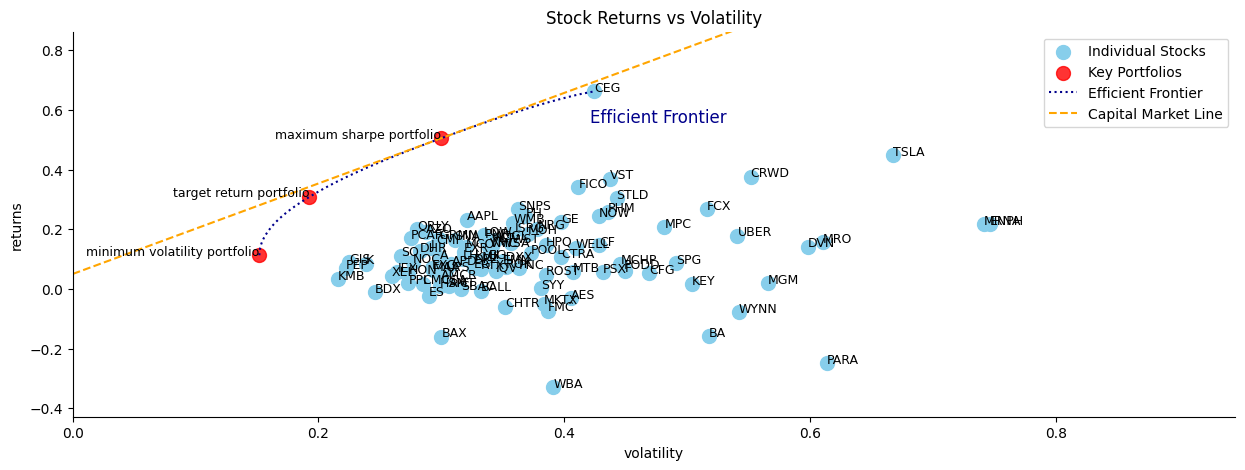

In [46]:
# Call the base chart function
base_chart(volatility, mean_returns)

# Plot individual stocks and annotate tickers
plt.scatter(volatility, mean_returns, color='skyblue', s=100, label='Individual Stocks')
for i in range(len(mean_returns)):
    plt.text(volatility.iloc[i], mean_returns.iloc[i], mean_returns.index[i], fontsize=9)

# Plot key portfolios and annotate
key_portfolios.plot(kind='scatter', x='volatility', y='returns', s=100, alpha=0.8, color='red', label='Key Portfolios', ax=plt.gca())
for i, row in key_portfolios.iterrows():
    plt.text(row['volatility'], row['returns'], i, fontsize=9, color='black', ha='right')

# Plot the Efficient Frontier (assuming 'volatility' and 'returns' are the correct column names in ef_df)
ef_df.plot(kind='line', x='volatility', y='returns', color='darkblue', linestyle=':', label='Efficient Frontier', ax=plt.gca())

# Label the Efficient Frontier line
last_point = ef_df.iloc[-2]  # Second-to-last point in ef_df to position the label slightly above
plt.text(last_point['volatility'], last_point['returns'] - 0.1, 'Efficient Frontier', fontsize=12, color='darkblue', ha='left')

# Define the risk-free rate
risk_free_rate = 0.05  # Example value, adjust as needed

# Calculate the market portfolio's return and volatility
market_return = key_portfolios.loc['maximum sharpe portfolio']['returns']  # Extract the scalar value
market_volatility = key_portfolios.loc['maximum sharpe portfolio']['volatility']  # Extract the scalar value

# Add the Capital Market Line (CML)
cml_x = np.linspace(0, volatility.max(), 100)  # Generate 100 points for a smooth line
sharpe_slope = (market_return - risk_free_rate) / market_volatility  # Slope of the CML
cml_y = risk_free_rate + sharpe_slope * cml_x  # Calculate CML y-values

# Plot the CML
plt.plot(cml_x, cml_y, color='orange', linestyle='--', label='Capital Market Line')

# Add legend and display the chart
plt.legend()
plt.show()



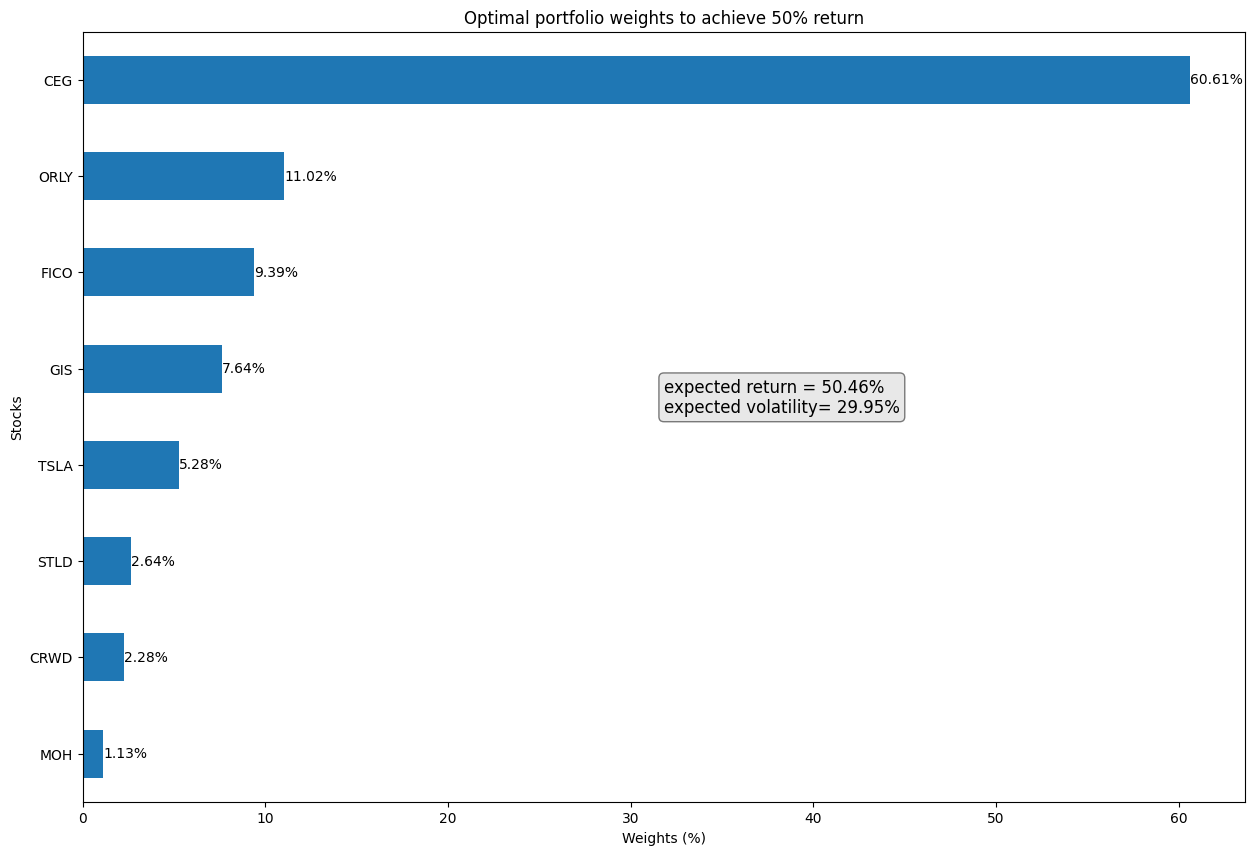

In [47]:
return_target= key_portfolios.loc['maximum sharpe portfolio']['returns']
selected_weights = target_portfolio(mean_returns, cov_matrix, return_target)['x']
expected_return = portfolio_return(selected_weights, mean_returns)
expected_volatility = portfolio_volatility(selected_weights, cov_matrix)
selected_weights_df = pd.DataFrame({
    'weights': list(selected_weights),
    'stocks': cov_matrix.index
}).set_index('stocks')
selected_weights_df['weights'] = selected_weights_df['weights'].apply(lambda x: round(x, 4))
selected_weights_df = selected_weights_df[selected_weights_df['weights'] != 0]
selected_weights_df.sort_values(by='weights', ascending=True)
selected_weights_df['weights'] = selected_weights_df['weights'] * 100  # Convert to percentages

# Plot the bar chart with a custom size
ax = selected_weights_df.sort_values(by='weights', ascending=True).plot(kind='barh', ylabel='Stocks', xlabel='Weights (%)', figsize=(15, 10))

# Add percentage labels at the end of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%',  # Use p.get_width() for horizontal bar
                (p.get_width() , p.get_y() + p.get_height() / 2),  # Position the label at the end of the bar
                ha='left', va='center')  # Align left and vertically center
textstr = f'expected return = {expected_return:.2%} \nexpected volatility= {expected_volatility:.2%}'
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)  # Customize the text box appearance
ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='left', bbox=props)

plt.title(f'Optimal portfolio weights to achieve {return_target:.0%} return')
plt.legend().remove()
# Show the plot
plt.show()



In [48]:
def calculate_betas(max_sharpe_weights, metrics, cov_matrix):
    """
    Calculate beta values for all stocks in the metrics DataFrame relative to the maximum Sharpe portfolio.

    Parameters:
    - max_sharpe_weights: DataFrame with weights for the stocks in the maximum Sharpe portfolio.
    - metrics: DataFrame containing returns and volatility data for all stocks.
    - cov_matrix: Full covariance matrix of all stocks.

    Returns:
    - A DataFrame with the original metrics and an added column for beta values for each stock.
    """
    # Extract portfolio stocks and weights from max_sharpe_weights
    portfolio_stocks = max_sharpe_weights.index

    portfolio_weights = max_sharpe_weights['weights']

    # Calculate the market portfolio variance using the maximum Sharpe portfolio weights
    filtered_cov_matrix = cov_matrix.loc[portfolio_stocks, portfolio_stocks]
    market_var = portfolio_weights.T @ filtered_cov_matrix.to_numpy() @ portfolio_weights

    # Initialize a Series to store beta values for all stocks
    beta_values = pd.Series(index=metrics.index, dtype=float)

    # Calculate beta for each stock in the entire metrics DataFrame
    for ticker in metrics.index:
        # Covariance of the stock with the market portfolio
        stock_cov_with_market = cov_matrix.loc[ticker, portfolio_stocks].to_numpy() @ portfolio_weights
        beta_values[ticker] = stock_cov_with_market / market_var

    # Add the beta column to the metrics DataFrame
    metrics['Beta'] = beta_values

    return metrics


In [49]:
msr_weights = pd.DataFrame(msr_portfolio['x'], index=metrics.index, columns=['weights'])
beta_df = calculate_betas(msr_weights, metrics, cov_matrix)



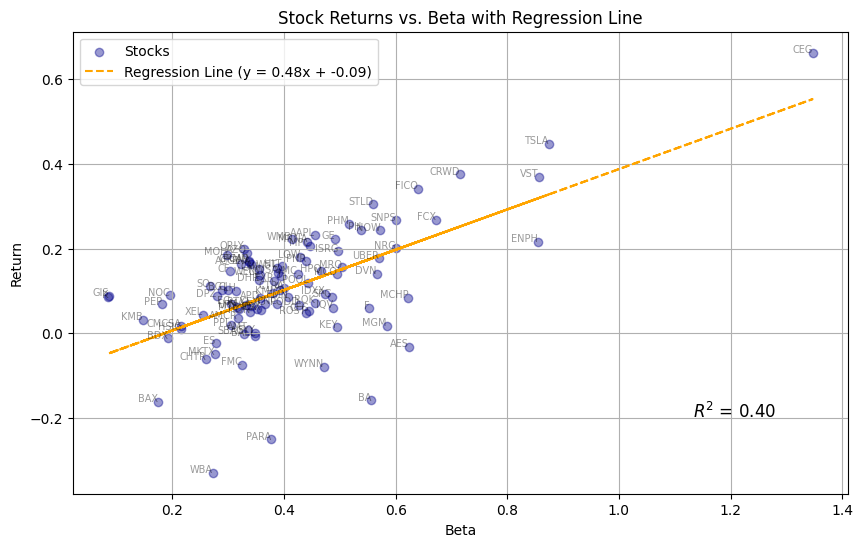

In [50]:
# Extract Beta and Return values for regression
x = beta_df['Beta']
y = beta_df['mean_returns']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the regression line
regression_line = slope * x + intercept


# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='darkblue', alpha=0.4, label='Stocks')
plt.plot(x, regression_line, color='orange', linestyle='--', label=f'Regression Line (y = {slope:.2f}x + {intercept:.2f})')


# Add labels for each stock
for ticker in beta_df.index:
    plt.text(beta_df.loc[ticker, 'Beta'], beta_df.loc[ticker, 'mean_returns'], ticker, fontsize=7, alpha=0.4, ha='right')

# Display R-squared value on the plot
plt.text(0.8, 0.2, f'$R^2$ = {r_value**2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Set plot labels and title
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Stock Returns vs. Beta with Regression Line')
plt.grid(True)
plt.legend()
plt.show()